## Data loading and understanding

### Data Set Information : Online Retail Data set
<i> This is a transnational data set which contains all the transactions occurring between 01/12/20210 and 09/12/2011 for a UK-based and registered non-store online retail.  
    Data can be downloaded from <a href = https://archive.ics.uci.edu/ml/datasets/online+retail > UCI Machine Learning Repository.<a/></i>   

### Attribute Information:

* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_excel('../data/raw/Online Retail.xlsx', header = 0)
data.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Each entry in the dataset corresponds to a single type of product purchased in a given transaction. In order to get all items in a single transaction, entries must by grouped by InvoiceNo.

In [4]:
data_by_invoice_no = data.groupby('InvoiceNo')
print("Total number of transactions: {0}".format(len(data_by_invoice_no.groups)))


Total number of transactions: 25900


Below there is a series of statistics regarding various particularities of this e-commerce dataset that will help us understand the data.

In [5]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

***Important note***: there are 135080 entries with unknown customer.

In [6]:
duplicated_entries_number = data.duplicated().sum()
print("Number of duplicated entries: {0}".format(duplicated_entries_number))

Number of duplicated entries: 5268


We'll remove duplicated entries in the data cleaning step.

Number of entries with negative quantity: 10624
Number of entries with negative unit price: 2
Total: 10626


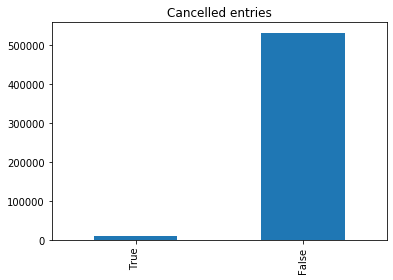

In [7]:
print("Number of entries with negative quantity: {0}".format(len(data[data['Quantity']<0])))
print("Number of entries with negative unit price: {0}".format(len(data[data['UnitPrice']<0])))

cancelled_entries = data[(data['Quantity']<0) | (data['UnitPrice']<0)]
print("Total: {0}".format(len(cancelled_entries)))

data['Cancelled'] = (data['Quantity']<0) | (data['UnitPrice']<0)
data['Cancelled'].value_counts().sort_values().plot(kind="bar", title="Cancelled entries")

So we have 10626 entries with negative quantity and unit price. They probably come from transactions that were canceled. In order to make sure, I'll check if the transactions containing this entries only contain entries with negative values for the 2 mentioned fields.

In [8]:
#Get all entries where InvoiceNo appears in the list of entries with negative quantity or unit price
cancelled_transactions_entries = data[data['InvoiceNo'].isin(cancelled_entries['InvoiceNo'])]
print("No of transaction entries containing products with negative quantity and unit price: {0}".format(len(cancelled_transactions_entries)))

No of transaction entries containing products with negative quantity and unit price: 10626


So we get the same number of entries: 10626. Therefore, this kind of transactions contain only entries of products with negative quantity or unit price. They represent cancelled transactions that will be removed in the data cleaning process.

In [9]:
cancelled_transactions = cancelled_entries.groupby('InvoiceNo')
print("Number of cancelled transactions: {0}".format(len(cancelled_transactions.groups)))

cancelled_transactions_percentage = len(cancelled_transactions.groups)/len(data_by_invoice_no.groups) * 100.0
print("Percentage of cancelled transactions: {:0.2f}%".format(cancelled_transactions_percentage))

print("Number of NOT cancelled transations: {0}".format(len(data_by_invoice_no.groups) - len(cancelled_transactions.groups)))



Number of cancelled transactions: 5174
Percentage of cancelled transactions: 19.98%
Number of NOT cancelled transations: 20726


In [10]:
by_customer = data.groupby('CustomerID')
print("Number of customers: {0}".format(len(by_customer.groups)))

not_cancelled_entries = data[(data['Quantity']>0) & (data['UnitPrice']>=0)]
not_cancelled_transactions = not_cancelled_entries.groupby('InvoiceNo')
not_canceled_by_customer = data.groupby('CustomerID')
users_no_not_canceled = len(not_canceled_by_customer.groups)
print("Number of customers with at least 1 not cancelled transaction: {0}".format(users_no_not_canceled))

print("Average number of purchased items per user: {0}".format(len(not_cancelled_entries)/users_no_not_canceled))
print("Average number of transactions per user: {0}".format(len(not_cancelled_transactions.groups)/users_no_not_canceled))

Number of customers: 4372
Number of customers with at least 1 not cancelled transaction: 4372
Average number of purchased items per user: 121.51944190301921
Average number of transactions per user: 4.7406221408966145


So we have the transactions of 4372 unique users. Each user made an average of 4.74 transactions and purchased a total of ~121.5 products.

In [11]:
unknown_customer_entries = data[data['CustomerID'].isna()]
print("Number of entries with missing CustomerID: {0}".format(len(unknown_customer_entries)))

unknown_customer_transactions = unknown_customer_entries.groupby('InvoiceNo')
print("Number of transactions with missing CustomerID: {0}".format(len(unknown_customer_transactions.groups)))

unknown_customer_percentage = len(unknown_customer_transactions.groups)/len(data_by_invoice_no.groups) * 100.0
print("Percentage of transaction with missing customer: {:0.2f}%".format(unknown_customer_percentage))

Number of entries with missing CustomerID: 135080
Number of transactions with missing CustomerID: 3710
Percentage of transaction with missing customer: 14.32%


In [12]:
unique_products = data['StockCode'].nunique()
print("Total number of products: {0}\n".format(unique_products))

by_products_quantity_sum_df = not_cancelled_entries.groupby(['StockCode', 'Description'])[['Quantity']].agg("sum").sort_values(by='Quantity', ascending=False)
print("Top most purchased products:")
print(by_products_quantity_sum_df)

Total number of products: 4070

Top most purchased products:
                                              Quantity
StockCode Description                                 
23843     PAPER CRAFT , LITTLE BIRDIE            80995
23166     MEDIUM CERAMIC TOP STORAGE JAR         78033
84077     WORLD WAR 2 GLIDERS ASSTD DESIGNS      55047
85099B    JUMBO BAG RED RETROSPOT                48478
85123A    WHITE HANGING HEART T-LIGHT HOLDER     37603
...                                                ...
85160a    WHITE BIRD GARDEN DESIGN MUG               1
85170A    SET/6 IVORY BIRD T-LIGHT CANDLES           1
21160     KEEP OUT GIRLS DOOR HANGER                 1
84510e    SET OF 4 GREEN CAROUSEL COASTERS           1
m         Manual                                     1

[4319 rows x 1 columns]


          Country  Number of customers
0  United Kingdom               354345
1         Germany                 9042
2          France                 8342
3            EIRE                 7238
4           Spain                 2485
5     Netherlands                 2363
6         Belgium                 2031
7     Switzerland                 1842
8        Portugal                 1462
9       Australia                 1185


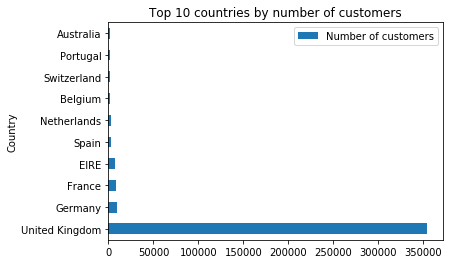

In [15]:
by_country = not_cancelled_entries.groupby(['Country'])
by_country_customers = by_country.agg({'CustomerID': 'count'}).rename(columns = {'CustomerID': 'Number of customers'}).sort_values('Number of customers', ascending=False).reset_index()
top_10_countries = by_country_customers.head(10)
print(top_10_countries)

top_10_countries.set_index('Country').plot(kind='barh', title = 'Top 10 countries by number of customers')


As we can see, the vast majority of customers come from United Kingdom.